In [1]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from skgarden import RandomForestQuantileRegressor

C:\Users\Wayne Linn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Wayne Linn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install scikit-garden
!pip install setuptools numpy scipy scikit-learn cython

ERROR: Could not find a version that satisfies the requirement scikit-garden (from versions: none)
ERROR: No matching distribution found for scikit-garden


In [4]:
X_train = pd.read_csv("A_Normalised_train_data.csv",index_col=0)
Y_train = pd.read_csv("A_Log_sales_train.csv",index_col=0)

In [5]:
best_pca = 170
best_ccp_alpha = 0.005
best_n_est = 100

In [6]:
Model = RandomForestQuantileRegressor(n_estimators=best_n_est)

In [7]:
pca1 = PCA(n_components=best_pca)
pca1.fit(X_train)
PX_train = pca1.transform(X_train)
RG1 = Model
RG1.fit(PX_train,Y_train.values.ravel())

RandomForestQuantileRegressor(n_estimators=100)

In [8]:
MSE(RG1.predict(PX_train),Y_train)

0.08178374677957817

In [9]:
result = pd.DataFrame(np.exp(Y_train))

In [10]:
result["Predicted_sales"] = np.exp(RG1.predict(PX_train))

In [11]:
MSE(result["sales"],result["Predicted_sales"])

286.0110830787868

In [12]:
residual = result['sales']-result['Predicted_sales']

In [13]:
Price=20
Cost=12
Salvage=8
Over=Cost - Salvage
Under=Price - Cost
Over, Under

(4, 8)

In [14]:
import scipy.stats as sct

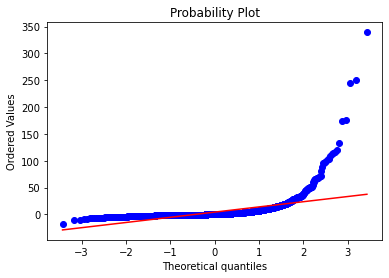

In [15]:
import scipy
scipy.stats.probplot(residual, dist="norm", plot=plt)
plt.show()

In [16]:
s = residual.std()
opt_dec_N=np.ceil(sct.norm.ppf(Under/(Under+Over))*s + result['Predicted_sales'])

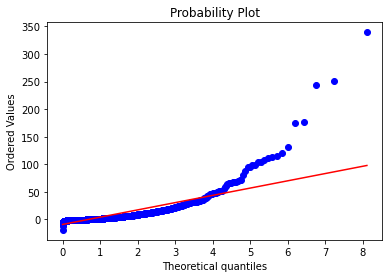

In [17]:
scipy.stats.probplot(residual, dist="expon", plot=plt)
plt.show()

In [18]:
opt_dec_E=np.ceil((-result['Predicted_sales'])*np.log(1-(Under/(Under+Over))))

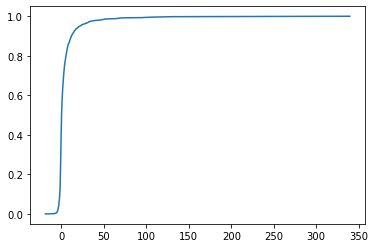

In [19]:
size = residual.shape[0]
step=1/size
jumps = [step*i for i in range(1,size+1)]
Sample = sorted(residual)
plt.plot(Sample,jumps)

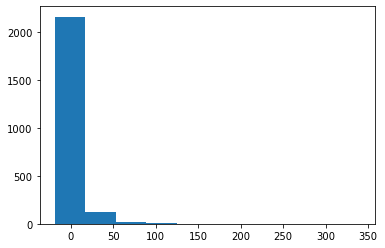

In [20]:
plt.hist(Sample)
plt.show()

In [21]:
def inv(sample,jump,area):
    size = len(sample)
    temp=0
    i=0
    while temp<area:
        temp=jump[i]
        i+=1
    return sample[i]

In [22]:
offset = inv(Sample,jumps,2/3)
offset

2.0184188849056177

In [23]:
opt_dec_B = np.ceil(result['Predicted_sales']+offset)

In [24]:
#max profit for test data set
max_profit = result['sales'].sum()*(Price-Cost)
max_profit

449664.0

In [25]:
def profit(demand,inv):
    return (Price-Salvage)*np.minimum(demand,inv)-(Cost-Salvage)*inv

In [26]:
#Profit (Normal)
profit_lst_N = profit(result['sales'],opt_dec_N)
profit_lst_N.sum()

340072.0

In [27]:
#Profit (Exponential)
profit_lst_E = profit(result['sales'],opt_dec_E)
profit_lst_E.sum()

372512.0

In [28]:
#Profit (Empirical)
profit_lst_B = profit(result['sales'],opt_dec_B)
profit_lst_B.sum()

357208.0

In [36]:
profit_raw = profit(result['sales'],result['Predicted_sales'])
profit_raw.sum()

353103.7740768144

In [29]:
result.to_csv(".\\Model_Prediction\\1_Random_forest.csv")

In [30]:
final_x = pd.read_csv("A_Normalised_test_data.csv",index_col=0)

In [31]:
final_result = np.exp(RG1.predict(final_x))

In [32]:
final_result

array([ 9.12029141,  7.74107629,  8.33253289, ...,  6.98579596,
       29.97310096,  7.44856106])

In [33]:
max(final_result)

46.28902429053886